# Sentiment analysis con la regressione logistica: 👍 o 👎?

Il data set **`sentiment`** consiste di 3000 frasi (in lingua inglese) provenienti da recensioni utente nei siti `imdb.com`, `amazon.com`, `yelp.com`. Ogni frase è stata etichettata come proveniente da una recensione dal sentimento positivo oppure negativo. 

Useremo la **regressione logistica** per costruire un classificatore basato su questo dataset. 

Prima di iniziare, se necessario scaricare i dati dal link https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences. La cartella `sentiment_labelled_sentences` (contenente il file del dataset `full_set.txt`) deve essere posta all'interno di una sottocartella `data` nella stessa cartella di questo quaderno Jupyter.

## 1. Caricamento dei dati

In [1]:
%matplotlib inline
import string # useremo alcune funzioni Python di elaborazione stringhe
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) # dimensiona il font dei grafici
matplotlib.rc('ytick', labelsize=14)

Carichiamo ora i dati. 

In [2]:
## Leggiamo il dataset
with open("data/sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Rimuoviamo gli spazi all'inizio e alla fine di ogni esempio
content = [x.strip() for x in content]

In [3]:
## Proviamo a visualizzare i primi 5 esempi del dataset:
print(content[:5])

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0', 'Good case, Excellent value.\t1', 'Great for the jawbone.\t1', 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0', 'The mic is great.\t1']


In [4]:
## Separiamo le frasi dalle corrispondenti etichette, tramite il carattere di tabulazione '\t'
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Verifichiamo quanto fatto sui primi 5 esempi: 
print(sentences[:5])
print(labels[:5])

['So there is no way for me to plug it in here in the US unless I go by a converter.', 'Good case, Excellent value.', 'Great for the jawbone.', 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!', 'The mic is great.']
['0', '1', '1', '0', '1']


Il dataset consiste di 3000 frasi, ciascuna etichettata con `1` (se proviene da una recensione positiva) o `0` (se proviene da una recensione negativa). Per consistenza con il formato richiesto da scikit-learn, vogliamo però adottare la convenzione `+1`/`-1` e quindi dobbiamo trasformare le etichette. Per farlo, basta mappare ogni etichetta $y^{(i)}$ nell'etichetta $2y^{(i)}-1$. 

In [5]:
## Trasformiamo le etichette da '{0, 1}' in '{-1, +1}'
y = np.array(labels, dtype='int8')
y = 2*y - 1
y

array([-1,  1,  1, ..., -1, -1, -1], dtype=int8)

### Preprocessiamo i testi

Per mettere questo problema di predizione in una forma adatta alla classificazione lineare, dobbiamo preprocessare i dati testuali. Faremo quattro trasformazioni: 

1. Rimuoviamo la punteggiatura e i simboli numerici. 
2. Trasformiamo tutte le parole in minuscolo. 
3. Rimuoviamo le _stop word_. 
4. Convertiamo le frasi in vettori, utilizzando una rappresentazione _bag-of-words_. 

Iniziamo dai primi due passi. 

In [6]:
## La seguente funzione full_remove prende una stringa x e una lista di caratteri removal_list 
## e restituisce x con tutti i caratteri presenti in removal_list rimpiazzati da uno spazio (' ')
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Rimuoviamo i simboli numerici
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Rimuoviamo i simboli di punteggiatura
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Rendiamo tutte le frasi in minuscolo
sents_lower = [x.lower() for x in punc_less]

## Verifichiamo quanto fatto sui primi 5 esempi:
sents_lower[:5]

['so there is no way for me to plug it in here in the us unless i go by a converter ',
 'good case  excellent value ',
 'great for the jawbone ',
 'tied to charger for conversations lasting more than    minutes major problems  ',
 'the mic is great ']

### *Stop word*

Le *stop word* sono parole che vogliamo escludere in quanto crediamo che non contribuiscano informazione per il problema in esame. Di norma includono articoli come 'a' e 'the', pronomi come 'i' e 'they', e preposizioni come 'to' e 'from'. 
Abbiamo predisposto una brevissima lista di stop word, ma siete liberi di espanderla. Per esempio, delle liste più estese di stop word possono essere facilmente reperite sul web. 

In [7]:
## Definiamo le nostre stop word
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Rimuoviamo le stop word attraverso un filtro (vedi documentazione della funzione Python 'filter')
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

Che aspetto hanno le frasi, a questo punto?

In [8]:
sents_processed[:5]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great']

### Rappresentazione *bag-of-words*

Per poter usare un classificatore lineare sul nostro dataset, dobbiamo trasformare i dati testuali in dati numerici. Un modo classico di fare questo è utilizzare una rappresentazione _bag-of-words_. 

In questa rappresentazione, ogni parola è vista come un intero in `{1, 2, ..., V}` dove `V` è la taglia del nostro vocabolario. Inoltre, ogni frase è rappresentata da un vettore V-dimensionale $x$, in cui $x_i$ indica il numero di volte che la parola $i$ è presente nella frase. Ad esempio: 

$$
\mathcal{V} = \left[ \begin{array}{c} a \\ aardvark \\ \ldots \\ buy \\ \ldots \\ zygmurgy \end{array} \right]
\qquad
x = \left[ \begin{array}{c} 2 \\ 0 \\ \ldots \\ 1 \\ \ldots \\ 0 \end{array} \right]
$$

Per attuare questa trasformazione, faremo uso della classe `CountVectorizer` di `scikit-learn`. Metteremo un tetto massimo pari a 4500 feature, ovvero una parola sarà presente nel nostro vocabolario solo se è una delle 4500 parole più comuni dell'intero corpus. Si tratta di un passo spesso utile in quanto può eliminare errori di battitura o parole che occorrono troppo raramente per risultare utili. 


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

## Transformiamo i dati in una rappresentazione bag-of-words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
data_mat = data_features.toarray()

In [10]:
## Verifichiamo le prime 5 e le ultime 5 parole del vocabolario
print(vectorizer.get_feature_names()[:5])
print(vectorizer.get_feature_names()[-5:])

['aailiyah', 'abandoned', 'abhor', 'ability', 'able']
['yummy', 'yun', 'zero', 'zillion', 'zombie']


In [11]:
## Stampiamo il vettore x corrispondente al primo esempio
with np.printoptions(threshold=np.inf):
    print(data_mat[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Partizionamento in training set e test set

Infine, suddividiamo i dati in un training set di 2500 frasi ed un test set di 500 frasi (di cui 250 positive e 250 negative). 

In [12]:
## Partizioniamo i dati in test set e training set
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), 
                      np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("Dati di training:\t ", train_data.shape)
print("Dati di test:\t\t ", test_data.shape)

Dati di training:	  (2500, 4500)
Dati di test:		  (500, 4500)


## 2. Apprendimento di un modello di regressione logistica

Potremmo costuire la regressione logistica implementando l'algoritmo Stochastic Gradient Descent (SGD) con la regola di aggiornamento vista a lezione, ma in questo caso decidiamo di utilizzare l'algoritmo SGD già fornito con `scikit-learn`. 

**Nota bene**. A causa dell'aleatorietà della procedura SGD, diverse esecuzioni costruiranno modelli leggermente diversi (e quindi valori leggermente diversi dell'errore). Se si vuole assicurare la ripetibilità degli esperimenti, si può impostare il seme del generatore pseudocasuale utilizzando l'opzione `random_state`. 

In [13]:
from sklearn.linear_model import SGDClassifier

## Fit di un classificatore logistico sui dati di training
clf = SGDClassifier(loss="log", penalty="l2", alpha=0.0001, learning_rate='constant', eta0=0.03, max_iter=1000, 
                    random_state=0)
clf.fit(train_data, train_labels)

## Estraiamo il vettore dei parametri (w0, w1, ..., wd) del modello di regressione logistica
omega = clf.coef_[0,:] # coefficienti (w1, ..., wd)
w0 = clf.intercept_    # termine costante w0

## Costruiamo le predizioni sul training set e sul test set
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

## Calcoliamo il numero di errori sul train set e sul test set
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))  # (preds_train > 0.0)[i] è 1 se e solo se l'esempio i
                                                                  # è classificato dal modello come positivo
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

## Stampiamo il tasso di errore sul train set e sul test set
print("Tasso di errore di training:\t\t ", float(errs_train)/len(train_labels))
print("Tasso di errore di test:\t\t ", float(errs_test)/len(test_labels))

Tasso di errore di training:		  0.0188
Tasso di errore di test:		  0.152


## 3. Analisi del margine

Come sappiamo, il modello di regressione logistica non produce solo classificazioni, ma anche stime delle probabilità condizionate. Queste possono essere recuperate tramite il metodo `predict_proba` della classe `SGDClassifier`. 

Diremo che `x` ha **margine** `gamma` se (secondo il modello di regressione logistica) `Pr(y=1|x) > (1/2)+gamma` oppure `Pr(y=1|x) < (1/2)-gamma`. 
La seguente funzione **margin_counts** riceve in input il classificatore (`clf`, precedentemente costruito), il test set (`test_data`), e un valore di `gamma`, e calcola quanti punti del test set hanno un margine almeno pari a `gamma`.

In [14]:
## Restituisce il numero di esempi di test per i quali Pr(y=1|x) è compresa in [0, 0.5 - gamma) o (0.5 + gamma, 1]
def margin_counts(clf, test_data, gamma):
    ## Calcola la probabilità (di essere positivo) assegnata ad ogni esempio di test
    preds = clf.predict_proba(test_data)[:,1]
    ## Trova gli esempi per cui la predizione è lontana almeno gamma da 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    return float(len(margin_inds))

Ora grafichiamo la distribuzione (cumulativa) dei valori di margine del test set. 

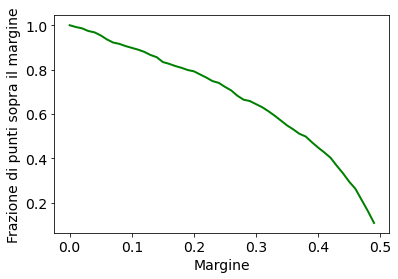

In [15]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_counts(clf, test_data, g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margine', fontsize=14)
plt.ylabel('Frazione di punti sopra il margine', fontsize=14)
plt.show()

Ci chiediamo ora: *I punti `x` con margine maggiore hanno maggiore probabilità di essere classificati correttamente?*

Per verificarlo, definiamo una funzione **margin_errors** che calcola la frazione di punti misclassificati aventi  margine almeno `gamma`. 

In [16]:
## Restituisce il tasso di errore delle predizioni comprese negli intervalli [0, 0.5 - gamma) and (0.5 + gamma, 1]
def margin_errors(clf, test_data, test_labels, gamma):
    ## Calcoliamo la probabilità su ogni esempio di test
    preds = clf.predict_proba(test_data)[:,1]
    
    ## Troviamo gli esempi per i quali la predizione è lontana almeno gamma da 0.5
    margin_inds = np.where((preds > (0.5+gamma)) | (preds < (0.5-gamma)))[0]
    
    ## Calcoliamo il tasso di errore su quegli esempi
    num_errors = np.sum((preds[margin_inds] > 0.5) != (test_labels[margin_inds] > 0.0))
    return float(num_errors)/len(margin_inds)

A questo punto possiamo graficare la relazione tra il margine ed il tasso di errore. 

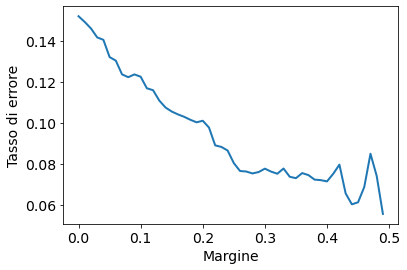

In [17]:
## Crea una griglia di valori per gamma
gammas = np.arange(0, 0.5, 0.01)

## Calcola margin_errors per gli esempi di test per ogni valore di g
f = np.vectorize(lambda g: margin_errors(clf, test_data, test_labels, g))

## Grafica il risultato
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Tasso di errore', fontsize=14)
plt.xlabel('Margine', fontsize=14)
plt.show()

## 4. Parole molto influenti

Infine, cerchiamo di **interpretare** parzialmente il modello di regressione logistica fin qui costruito. 

Quali parole risultano le più importanti per decidere se una frase contiene un sentimento positivo? Come prima approssimazione, possiamo prendere le parole i cui coefficienti in `omega` hanno valore massimo. 

Allo stesso modo, possiamo cercare le parole i cui coefficienti in `omega` hanno valore più negativo, e interpretarle come le parole più influenti per le predizioni negative. 

In [18]:
## Convertiamo il nostro vocabolario in una lista ordinata alfabeticamente:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

## Costruiamo gli indici di un ordinamento dei coefficienti omega (dal più negativo al più positivo)
inds = np.argsort(omega)

## Le 50 parole con valore più negativo sono le prime 50
neg_inds = inds[:50]
print("\nParole altamente negative: ")
print([str(x) for x in list(vocab[neg_inds])])

## Le 50 parole con valore più positivo sono le ultime 50
pos_inds = inds[-50:]
print("\nParole altamente positive: ")
print([str(x) for x in list(vocab[pos_inds])[::-1]])


Parole altamente negative: 
['poor', 'bad', 'disappointment', 'worst', 'waste', 'disappointing', 'not', 'doesn', 'wasn', 'aren', 'sucked', 'awful', 'horrible', 'slow', 'avoid', 'terrible', 'rude', 'bland', 'stupid', 'average', 'fails', 'unfortunately', 'then', 'didn', 'dirty', 'make', 'worse', 'difficult', 'return', 'lacks', 'crap', 'mediocre', 'piece', 'wouldn', 'plot', 'torture', 'dont', 'lame', 'don', 'plug', 'hours', 'guess', 'failed', 'unreliable', 'sucks', 'boring', 'never', 'at', 'put', 'directing']

Parole altamente positive: 
['great', 'love', 'nice', 'perfect', 'awesome', 'excellent', 'delicious', 'loved', 'beautiful', 'works', 'happier', 'fantastic', 'liked', 'comfortable', 'amazing', 'best', 'good', 'wonderful', 'funny', 'interesting', 'enjoyed', 'cool', 'fun', 'friendly', 'happy', 'incredible', 'easy', 'both', 'plus', 'sturdy', 'rocks', 'must', 'definitely', 'well', 'years', 'pleased', 'fast', 'masculine', 'screamy', 'joy', 'recommend', 'carry', 'played', 'scottsdale', 'n